In [ ]:
!pip install yfinance snntorch torch matplotlib pandas numpy


In [ ]:
!pip install scikit-learn


In [14]:
import pandas as pd

In [25]:
from data_loader import load_price_data
from preprocess import prepare_labels, create_features

# Load and preprocess data
data = load_price_data("SPY", "2017-01-01", "2022-01-01")
df = prepare_labels(data)

# Create feature and label arrays
X, Y = create_features(df)

# Split into training and test sets
split = int(0.8 * len(X))
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]
prices_test = df['Close'].values[split:] 


[*********************100%***********************]  1 of 1 completed

Downloaded columns: MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Check class distribution
unique, counts = np.unique(Y_train, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

# Compute balanced class weights
weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
print("Class weights:", weights)


Label distribution: {np.int64(0): np.int64(66), np.int64(1): np.int64(886), np.int64(2): np.int64(50)}
Class weights: [5.06060606 0.37697517 6.68      ]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest for feature importance analysis
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

# Display feature importance
feature_names = ['Ret_1', 'Ret_3', 'EMA_Momentum', 'Momentum', 'Volatility']
importances = clf.feature_importances_
for name, score in zip(feature_names, importances):
    print(f"{name}: {score:.4f}")


In [2]:
from train import train_model
model = train_model(X_train, Y_train, num_epochs=20)


Epoch 1: Loss = 0.8454, Accuracy = 42.12%
Epoch 2: Loss = 0.3979, Accuracy = 84.73%
Epoch 3: Loss = 0.3798, Accuracy = 84.13%
Epoch 4: Loss = 0.3623, Accuracy = 84.93%
Epoch 5: Loss = 0.3605, Accuracy = 84.63%
Epoch 6: Loss = 0.3571, Accuracy = 85.13%
Epoch 7: Loss = 0.3530, Accuracy = 85.43%
Epoch 8: Loss = 0.3496, Accuracy = 86.33%
Epoch 9: Loss = 0.3479, Accuracy = 86.63%
Epoch 10: Loss = 0.3427, Accuracy = 86.13%
Epoch 11: Loss = 0.3567, Accuracy = 86.13%
Epoch 12: Loss = 0.3482, Accuracy = 86.33%
Epoch 13: Loss = 0.3427, Accuracy = 85.83%
Epoch 14: Loss = 0.3366, Accuracy = 86.13%
Epoch 15: Loss = 0.3385, Accuracy = 86.23%
Epoch 16: Loss = 0.3400, Accuracy = 86.83%
Epoch 17: Loss = 0.3283, Accuracy = 86.23%
Epoch 18: Loss = 0.3294, Accuracy = 86.83%
Epoch 19: Loss = 0.3308, Accuracy = 86.83%
Epoch 20: Loss = 0.3239, Accuracy = 86.53%


In [ ]:
from test_and_backtest import predict, backtest, plot_equity

# Predict using SNN model
preds = predict(model, X_test)

# Strategy equity curve
equity_curve_snn = backtest(prices_test, preds)

# Baseline: Buy-and-hold (always long)
buy_and_hold = [0] * len(preds)
equity_curve_hold = backtest(prices_test, buy_and_hold)

# Plot both
import matplotlib.pyplot as plt

plt.plot(equity_curve_snn, label='SNN Strategy')
plt.plot(equity_curve_hold, label='Buy & Hold')
plt.title("Equity Curve Comparison")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on training set
model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(X_train, dtype=torch.float32), time_steps=20)
    preds = torch.argmax(outputs, dim=1).numpy()

print("Confusion Matrix:")
print(confusion_matrix(Y_train, preds))

print("\nClassification Report:")
print(classification_report(Y_train, preds, target_names=["Sell", "Hold", "Buy"]))


In [3]:
import numpy as np
unique, counts = np.unique(Y_train, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(66), np.int64(1): np.int64(886), np.int64(2): np.int64(50)}


In [4]:
df = prepare_labels(data)


In [5]:
df

Price,Close,High,Low,Open,Volume,Return,Signal
Date,,,,,,,
2017-01-04,197.867294,198.015750,197.020214,197.028942,78744400,0.005949,1.0
2017-01-05,197.710190,197.867387,196.906775,197.596673,78379000,-0.000794,1.0
2017-01-06,198.417480,198.889045,197.273475,197.823645,71559900,0.003577,1.0
2017-01-09,197.762512,198.295212,197.727574,198.155485,46939700,-0.003301,1.0
2017-01-10,197.762512,198.627049,197.369527,197.779968,63771900,0.000000,1.0
...,...,...,...,...,...,...,...
2021-12-23,449.026398,450.543504,447.156258,447.261201,56439700,0.006222,1.0
2021-12-27,455.381042,455.428739,450.371718,450.419414,56808600,0.014152,1.0
2021-12-28,455.008911,456.859978,454.236046,455.819951,47274600,-0.000817,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2017-01-04 to 2021-12-30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1257 non-null   float64
 1   High    1257 non-null   float64
 2   Low     1257 non-null   float64
 3   Open    1257 non-null   float64
 4   Volume  1257 non-null   int64  
 5   Return  1257 non-null   float64
 6   Signal  1257 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.6 KB


In [7]:
df['Signal'].value_counts()

Signal
1.0    1123
0.0      74
2.0      60
Name: count, dtype: int64

In [8]:
df.describe()


Price,Close,High,Low,Open,Volume,Return,Signal
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1257.000000,1257.000000
mean,286.157901,287.595471,284.494610,286.124035,8.238221e+07,0.000737,0.988862
std,67.986025,68.217442,67.656477,67.947004,4.506082e+07,0.011886,0.326441
min,197.282257,197.867387,196.452660,197.028942,2.027000e+07,-0.109424,0.000000
25%,238.164505,239.445719,236.461792,238.446116,5.518210e+07,-0.002938,1.000000
50%,263.102051,264.218674,261.593390,262.957794,6.979800e+07,0.000930,1.000000
75%,318.562073,320.373696,316.133915,319.215677,9.404060e+07,0.005915,1.000000
max,455.590973,457.041346,454.236046,456.020391,3.922207e+08,0.090603,2.000000


In [9]:
df.corr()


Price,Close,High,Low,Open,Volume,Return,Signal
Price,,,,,,,
Close,1.000000,0.999574,0.999640,0.999439,-0.153004,0.039670,0.019402
High,0.999574,1.000000,0.999279,0.999699,-0.134388,0.020850,0.022328
Low,0.999640,0.999279,1.000000,0.999602,-0.165751,0.027037,0.021929
Open,0.999439,0.999699,0.999602,1.000000,-0.147264,0.015732,0.022081
Volume,-0.153004,-0.134388,-0.165751,-0.147264,1.000000,-0.233463,-0.013343
Return,0.039670,0.020850,0.027037,0.015732,-0.233463,1.000000,-0.135670
Signal,0.019402,0.022328,0.021929,0.022081,-0.013343,-0.135670,1.000000


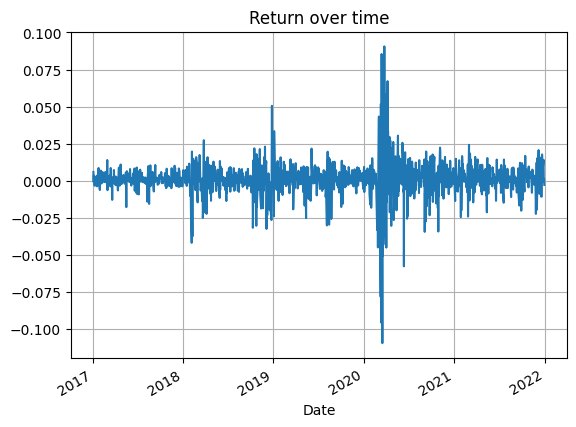

In [10]:
import matplotlib.pyplot as plt

df['Return'].plot(title='Return over time')
plt.grid(True)
plt.show()


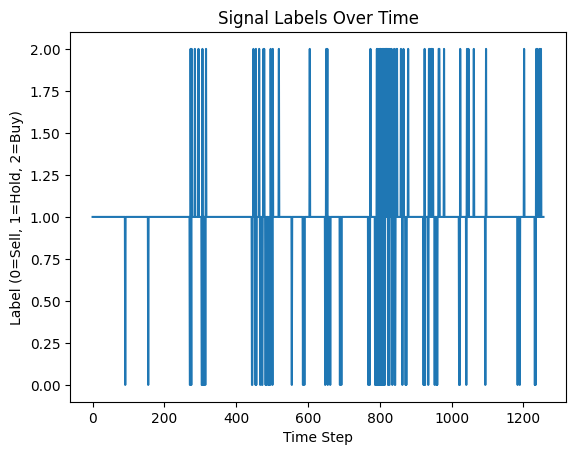

In [11]:
plt.plot(df['Signal'].values)
plt.title("Signal Labels Over Time")
plt.xlabel("Time Step")
plt.ylabel("Label (0=Sell, 1=Hold, 2=Buy)")
plt.show()


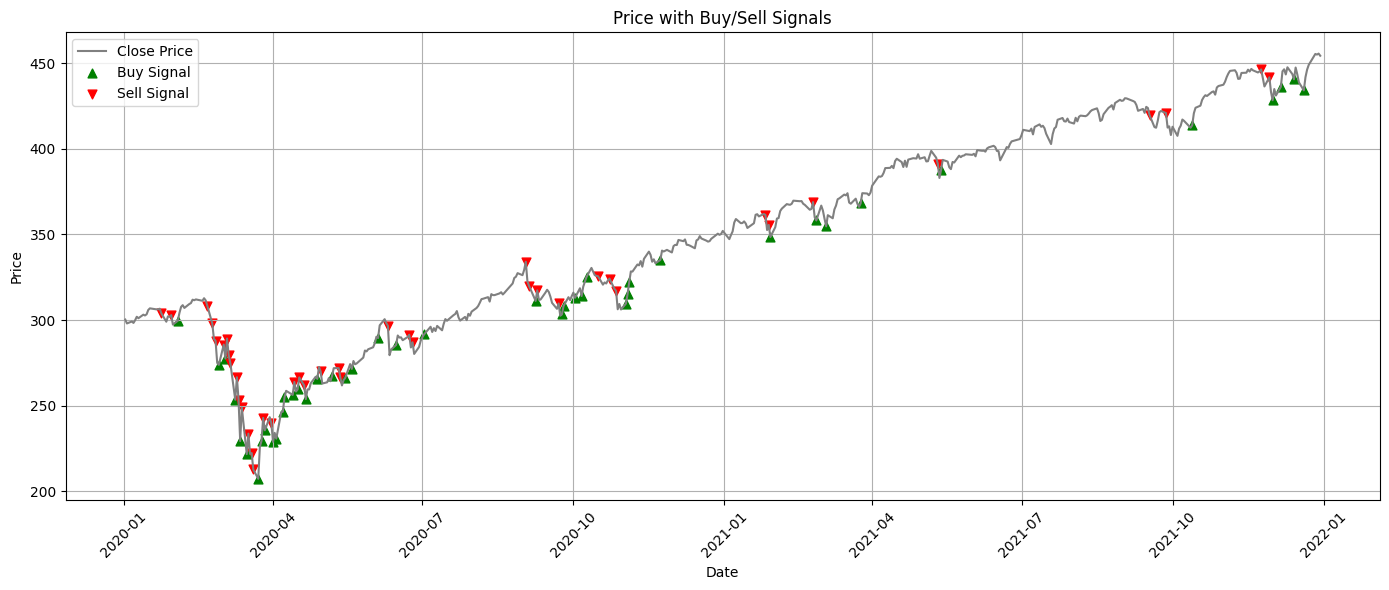

In [21]:
import matplotlib.pyplot as plt

# Drop rows where price or signal might be NaN
df_plot = df.dropna(subset=['Close', 'Signal'])

# Convert index to datetime if not already
if not isinstance(df_plot.index, pd.DatetimeIndex):
    df_plot.index = pd.to_datetime(df_plot.index)

# Filter out unnecessary early data (optional)
df_plot = df_plot[df_plot.index > '2020']

# Extract
price = df_plot['Close']
signals = df_plot['Signal']
buy_signals = signals == 2
sell_signals = signals == 0

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_plot.index, price, label='Close Price', color='gray')

plt.scatter(df_plot.index[buy_signals], price[buy_signals], marker='^', color='green', s=40, label='Buy Signal')
plt.scatter(df_plot.index[sell_signals], price[sell_signals], marker='v', color='red', s=40, label='Sell Signal')

plt.title("Price with Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
import numpy as np

def calculate_cumulative_returns(prices, signals):
    equity = [100000]  # starting portfolio
    for i in range(len(signals) - 1):
        position = 1 if signals[i] == 2 else -1 if signals[i] == 0 else 0
        ret = (prices[i+1] - prices[i]) * position
        equity.append(equity[-1] + ret)
    return np.array(equity)


In [23]:
equity_snn = calculate_cumulative_returns(prices_test, preds)

# Buy-and-hold: always long
hold_signals = [2] * len(preds)
equity_hold = calculate_cumulative_returns(prices_test, hold_signals)


NameError: name 'preds' is not defined

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(equity_snn, label='SNN Strategy', linewidth=2)
plt.plot(equity_hold, label='Buy & Hold', linewidth=2, linestyle='--')

plt.title("Cumulative Returns Comparison")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'equity_snn' is not defined

<Figure size 1400x600 with 0 Axes>